In [51]:
#import the necessary libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,os.path
import seaborn as sns
import cv2 
import shutil

from PIL import ImageFont, Image
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Reshape, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

import random
import matplotlib.image as mpimg
%matplotlib inline

# Image manipulation.
import PIL.Image
from IPython.display import display
import glob
import base64
from io import BytesIO
from IPython.display import HTML

In [4]:
df = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

In [5]:
train_df = pd.read_csv('/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/test.csv')

In [6]:
dataset = [train_df,test_df]

In [7]:
for data in dataset:
  data['image_id'] = [filename + '.jpg' for filename in data['image_id']]

In [24]:
def get_thumbnail(path):           
    i = Image.open(path)
    i.thumbnail(size=(150, 150), resample=Image.LANCZOS) #lanczos is a interpolation technique
    return i

def image_base64(im):
    if isinstance(im, str): #if im is of str dtype
        im = get_thumbnail(im)
        
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode() #gives base64 encoded jpeg format and then decoding to UTF-8 encoded string

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [26]:
df_test = train_df.sample(30)
df_test['file'] = df_test.image_id.map(lambda id: f'../input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train/{id}')
df_test['image'] = df_test.file.map(lambda f: get_thumbnail(f)) 
df_test.head()

image_id                   breed  \
997   0cd3419120.jpg  agkistrodon-piscivorus   
193   4181a2c939.jpg   nerodia-erythrogaster   
2715  7c49c0b98c.jpg  agkistrodon-piscivorus   
3376  68fb39ae84.jpg     thamnophis-sirtalis   
2404  2b143001e1.jpg  pantherophis-obsoletus   

                                                   file  \
997   ../input/hackerearth-deep-learning-identify-th...   
193   ../input/hackerearth-deep-learning-identify-th...   
2715  ../input/hackerearth-deep-learning-identify-th...   
3376  ../input/hackerearth-deep-learning-identify-th...   
2404  ../input/hackerearth-deep-learning-identify-th...   

                                                  image  
997   <PIL.JpegImagePlugin.JpegImageFile image mode=...  
193   <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2715  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3376  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2404  <PIL.JpegImagePlugin.JpegImageFile image mode=...


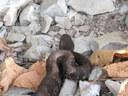
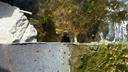
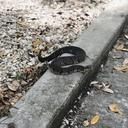
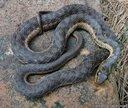
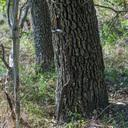
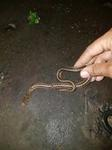
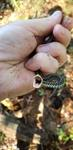
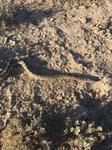
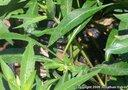
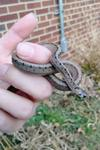
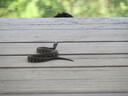
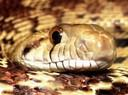
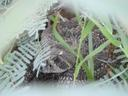
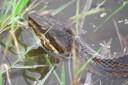
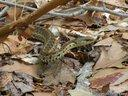
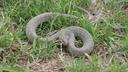
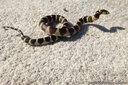
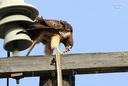
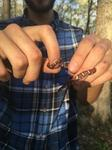
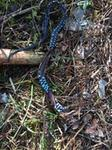
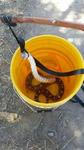
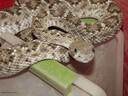
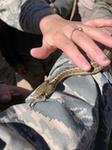
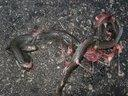
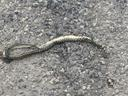
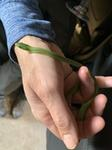
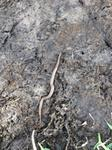
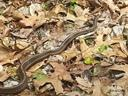
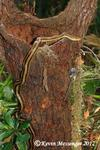
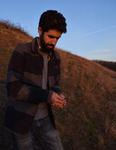

In [28]:
HTML(df_test[['breed', 'image']].to_html(formatters={'image': image_formatter}, escape=False))

In [29]:
train_image_dir = '../input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train/' 

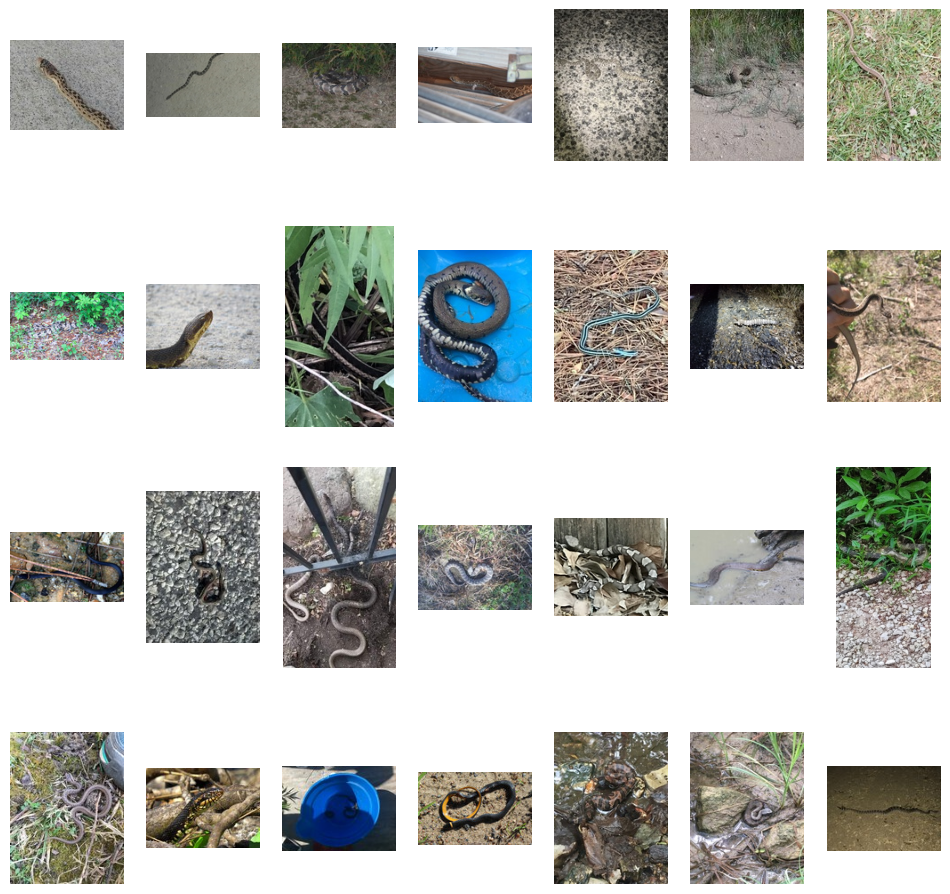

In [32]:
plt.figure(figsize=(12,12))

for k in range(28):
    randomImg = random.choice(
    [
        x for x in os.listdir(train_image_dir)
        if os.path.isfile(os.path.join(train_image_dir, x))
    ]
)
    
    imageFilename = train_image_dir + str(randomImg) 
    
    plt.subplot(4,7,k+1); 
    
    plt.imshow(mpimg.imread(imageFilename), cmap='gray')

    plt.axis('off')

In [33]:
new_width = 28
new_height = 28

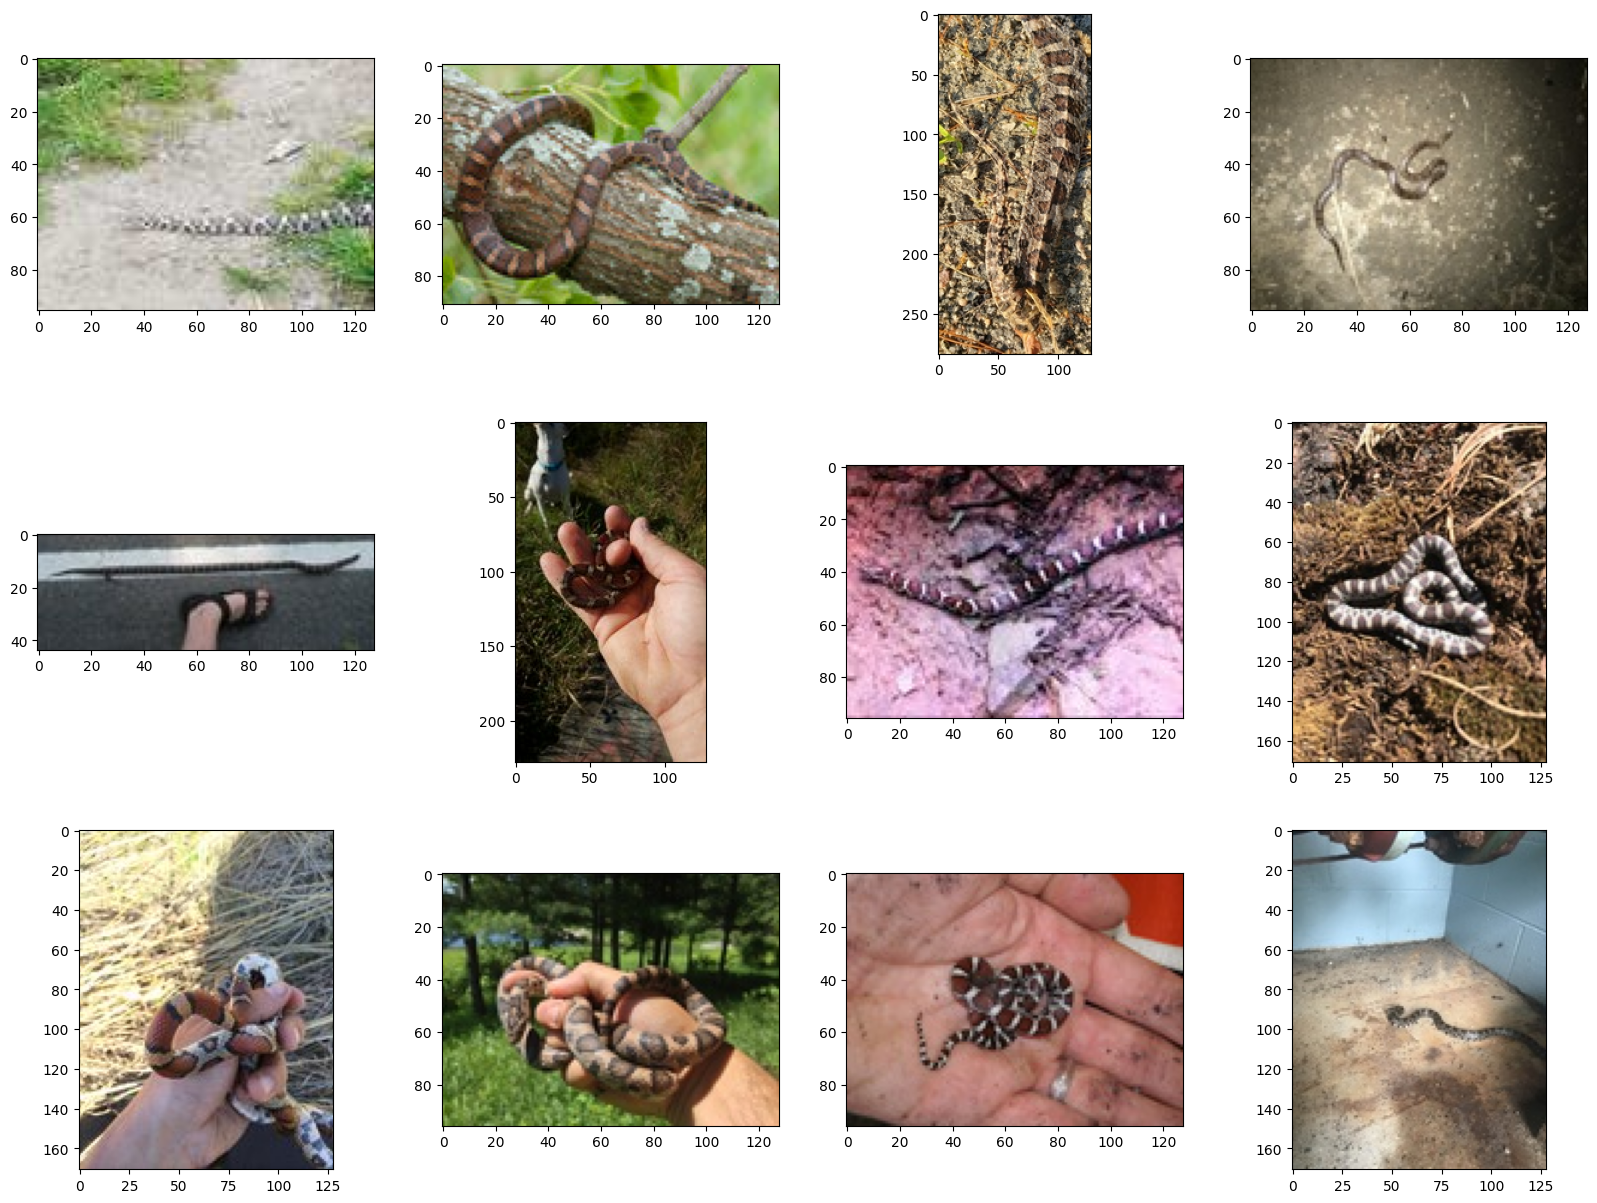

In [36]:
fig = plt.figure(figsize = (20, 15))
for idx, img_name in enumerate(train_df[train_df['breed'] == 'lampropeltis-triangulum']['image_id'][:12]):
    y = fig.add_subplot(3, 4, idx+1)
    img = cv2.imread(os.path.join(train_image_dir,img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     y.set_xlabel(img_name)
#     y.set_xlabel(train_df.loc[train_df['image_id'] == img_name]['breed'])
    y.imshow(img)

plt.show()

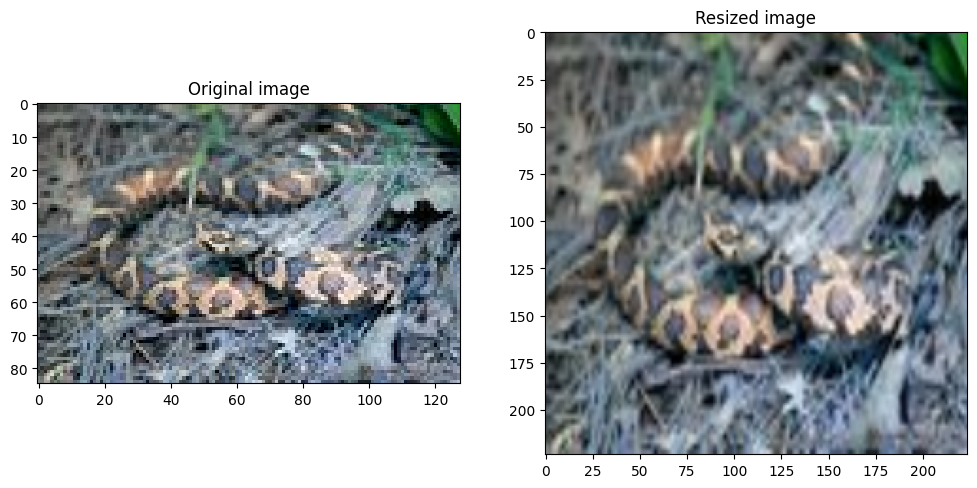

In [46]:
img = cv2.imread(os.path.join(train_image_dir,'5f0c970adf.jpg'))
image_resized = cv2.resize(img, (224,224))

fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img); ax[0].set_title('Original image')
ax[1].imshow(image_resized); ax[1].set_title('Resized image')
plt.show()

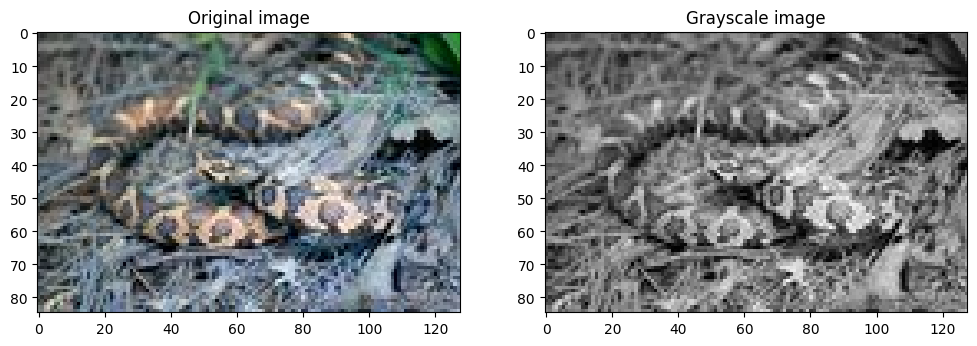

In [49]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img); ax[0].set_title('Original image')
ax[1].imshow(img_gray,cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('Grayscale image')
plt.show()

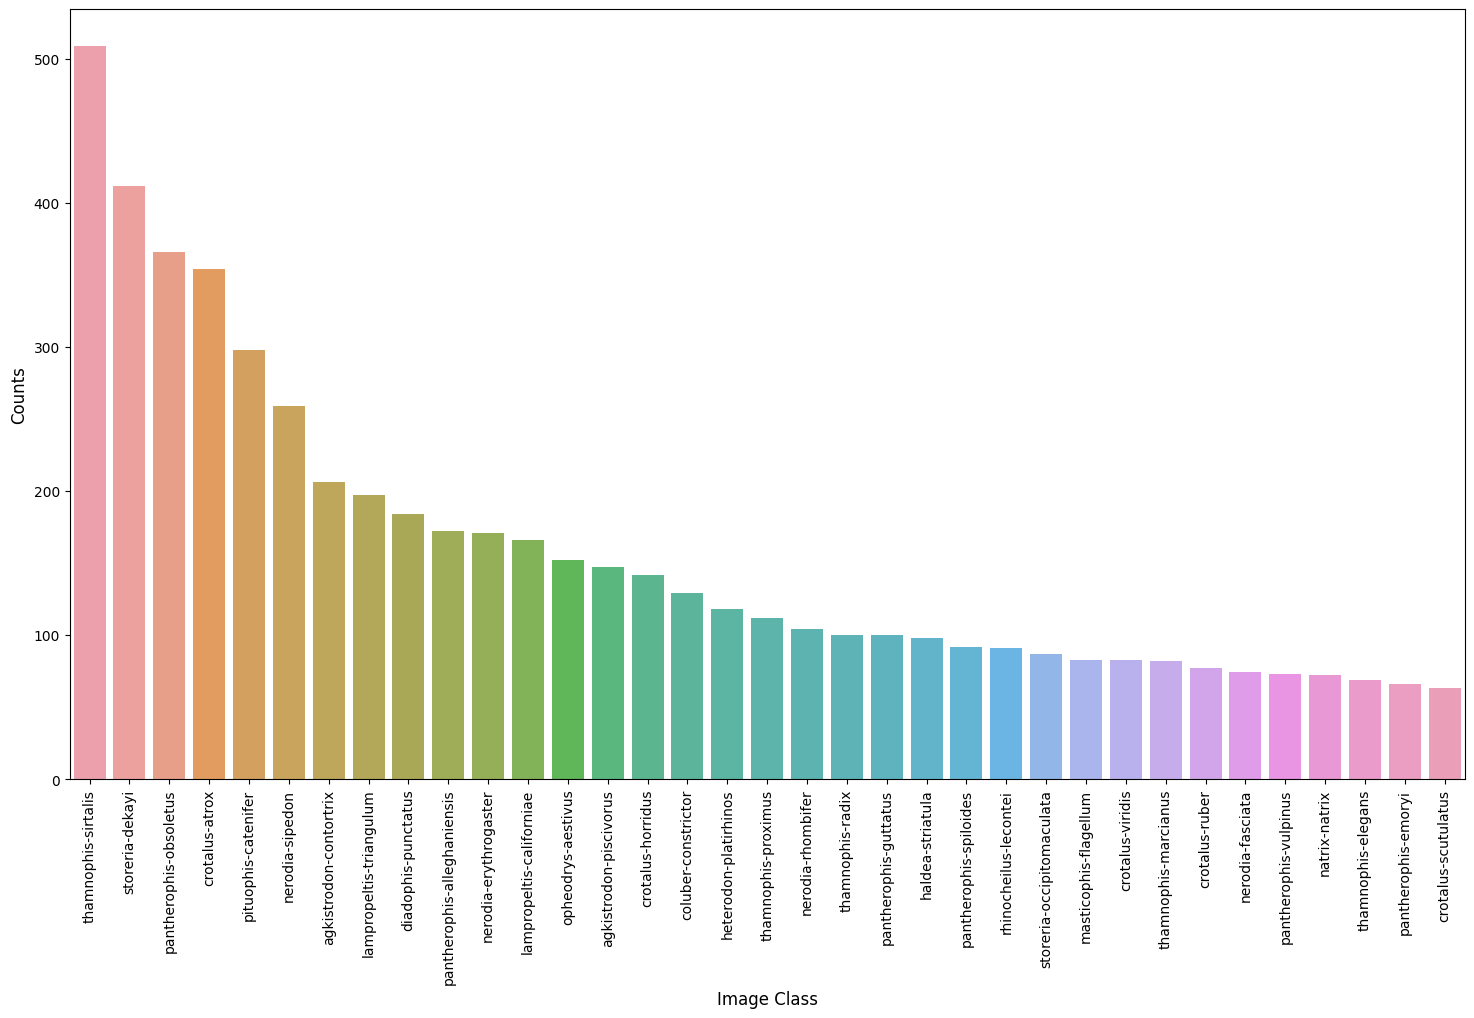

In [58]:
label_counts = train_df.breed.value_counts()
plt.figure(figsize = (18,10))
sns.barplot(x=label_counts.index,y=label_counts.values,alpha=0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

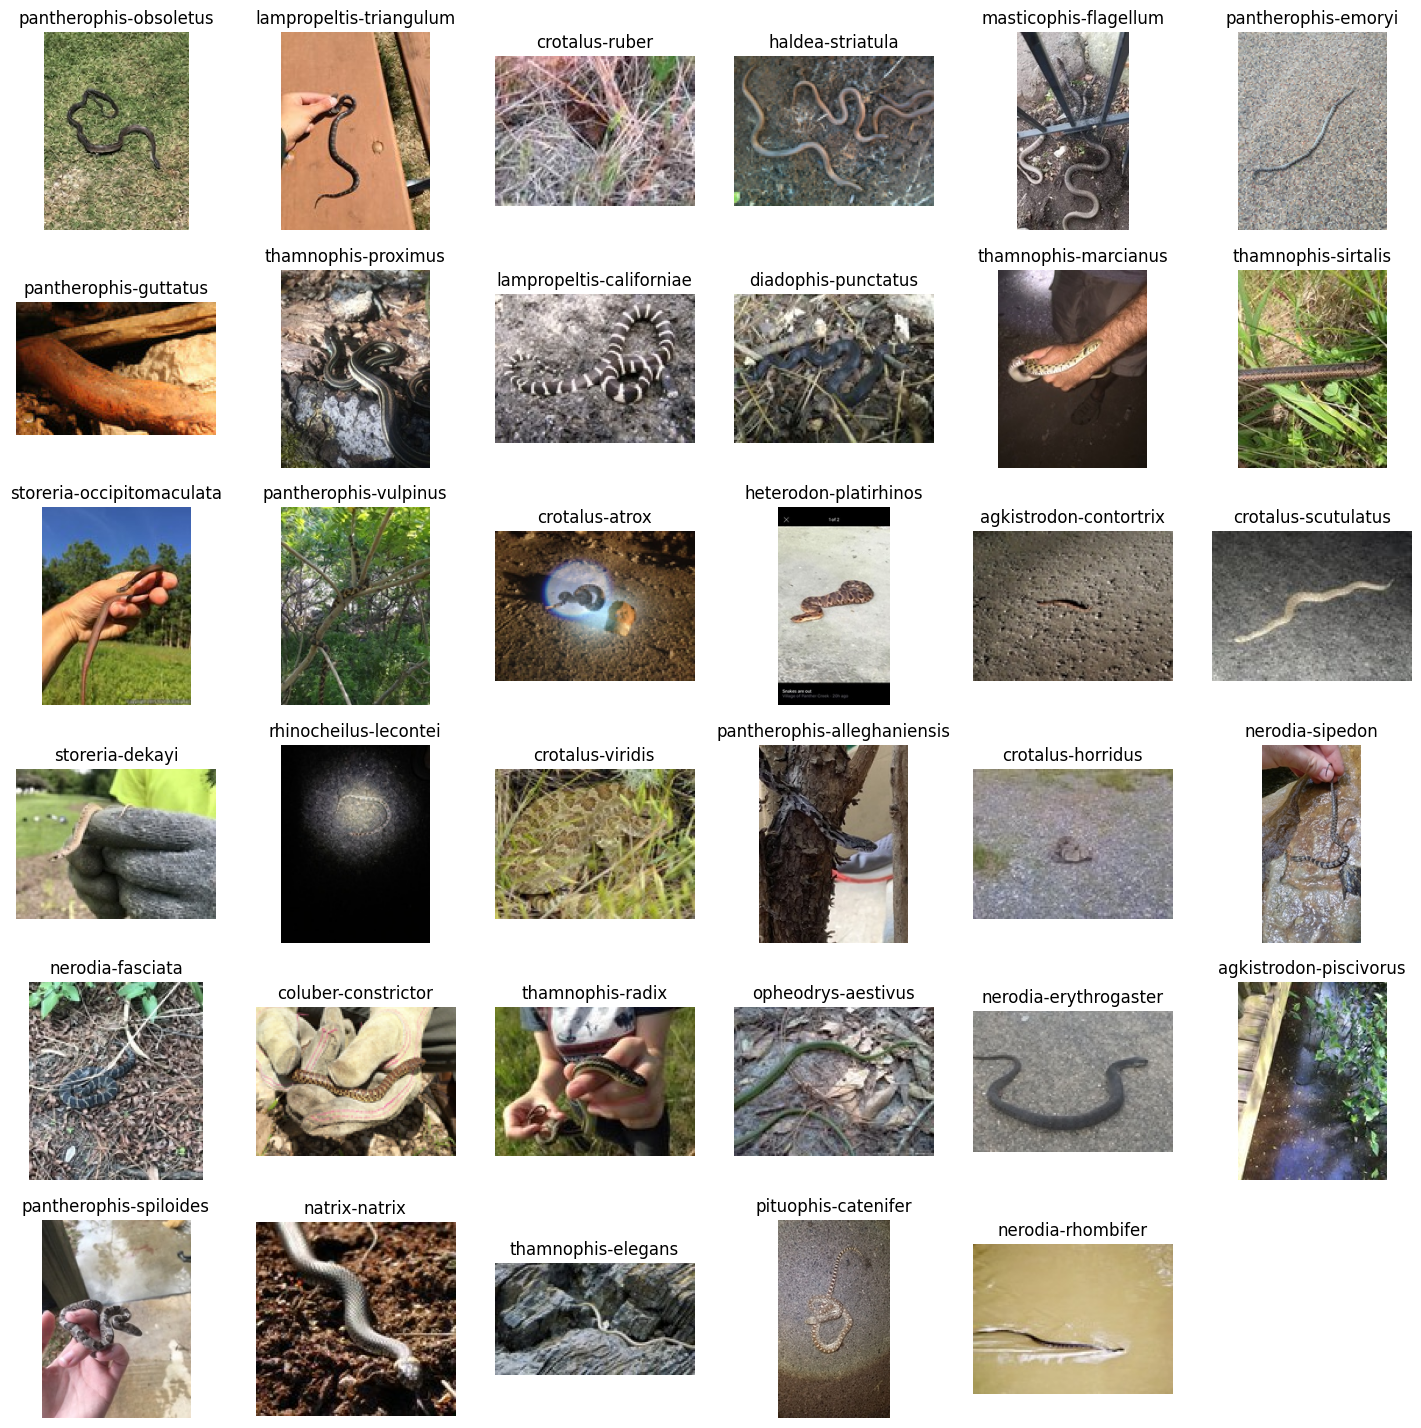

In [55]:
d = '/kaggle/working/dataset_imagenet_format/'
plt.figure(figsize=(18, 18))
k=0
for i in os.listdir(d):
    image = os.listdir(d+i)[0]
    Image.open(d+i+'/'+image)
    ax=plt.subplot(6,6,k+1)
    k=k+1
    plt.title(i)
    plt.axis("off")
    plt.imshow(Image.open(d+i+'/'+image))

In [18]:
# Producing Class Counts alphabetically
class_counts = train_df['breed'].value_counts()
class_counts = pd.DataFrame({'breed': class_counts.index, 'count': class_counts.values})
class_counts.sort_values(['breed'], inplace = True)
class_counts.reset_index(drop=True)

classes = class_counts['breed'].values.tolist()
print(classes)

['agkistrodon-contortrix', 'agkistrodon-piscivorus', 'coluber-constrictor', 'crotalus-atrox', 'crotalus-horridus', 'crotalus-ruber', 'crotalus-scutulatus', 'crotalus-viridis', 'diadophis-punctatus', 'haldea-striatula', 'heterodon-platirhinos', 'lampropeltis-californiae', 'lampropeltis-triangulum', 'masticophis-flagellum', 'natrix-natrix', 'nerodia-erythrogaster', 'nerodia-fasciata', 'nerodia-rhombifer', 'nerodia-sipedon', 'opheodrys-aestivus', 'pantherophis-alleghaniensis', 'pantherophis-emoryi', 'pantherophis-guttatus', 'pantherophis-obsoletus', 'pantherophis-spiloides', 'pantherophis-vulpinus', 'pituophis-catenifer', 'rhinocheilus-lecontei', 'storeria-dekayi', 'storeria-occipitomaculata', 'thamnophis-elegans', 'thamnophis-marcianus', 'thamnophis-proximus', 'thamnophis-radix', 'thamnophis-sirtalis']


In [19]:
# Creating new train data directory
#os.mkdir('dataset_imagenet_format/')

# Creating one folder for each of the image classes.
for cls in classes:
    os.mkdir('/kaggle/working/dataset_imagenet_format' + '/' + cls)

In [20]:
train_dir = '/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train'
new_train_dir = '/kaggle/working/dataset_imagenet_format'

In [10]:
# Copying the Train image files to their respective class folders in the training directory.
for index , row in train_df.iterrows():
    img_path = train_dir + '/' + row['image_id']
    dst_path = new_train_dir + '/' + row['breed'] + '/' + row['image_id']
    shutil.copy(img_path, dst_path)

In [11]:
train_data = df.flow_from_dataframe(train_df,
                                                directory='/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train',
                                                x_col = 'image_id',
                                                y_col = 'breed',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'sparse',
                                                subset = 'training')

Found 4407 validated image filenames belonging to 35 classes.


In [81]:
valid_data = df.flow_from_dataframe(train_df,
                                                directory='/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train',
                                                x_col = 'image_id',
                                                y_col = 'breed',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'sparse',
                                                subset = 'validation')

Found 1101 validated image filenames belonging to 35 classes.


In [100]:
#data pipeline
def build_data_pipeline(image_dir, train_df, test_df, augment_args=None):
    if augment_args:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, **augment_args)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_datagen = ImageDataGenerator(rescale=1./255) # unaffected by data augmentation

    #training data
    train_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='training',
        shuffle=True,
        seed=SEED
    )
    #validation data
    val_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='validation',
        shuffle=True,
        seed=SEED
    )
    #test data
    test_batches = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/test',
        x_col=X_COL,
        target_size=TARGET_SIZE,
        batch_size=1,   # prediction done one sample at a time
        class_mode=None,    # no class associated with test sample
        shuffle=False
    )
    return train_batches, val_batches, test_batches

In [101]:
CLASSES = list(train_df.breed.unique())
X_COL = train_df.columns[0]
Y_COL = train_df.columns[-1]
CLASS_MODE = 'categorical'
SEED = 40
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = TARGET_SIZE + (3, ) #3 channels for RGB

In [102]:
augment_args = {
    'rotation_range': 20, #degrees
    'shear_range': 0.1,
    'zoom_range': 0.2,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'horizontal_flip': True
}

image_dir = '/kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/dataset/train'

train_batches, val_batches, test_batches = build_data_pipeline(
    image_dir, train_df, test_df, augment_args
)

Found 4407 validated image filenames belonging to 35 classes.
Found 1101 validated image filenames belonging to 35 classes.
Found 2361 validated image filenames.


In [103]:
#model graphs
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].minorticks_on()
    ax[0].legend()
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].minorticks_on()
    ax[1].legend()
    plt.show()

In [104]:
#model fitting
def fit_model(model, train_batches, val_batches, epochs=10):
#     verbose = 2 if epochs <= 10 else 0
    verbose = 1
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=2e-4,
        patience=20,
        verbose=0,
        mode='max',
        restore_best_weights=True
    )
    history = model.fit(
        x=train_batches,
        epochs=epochs,
        callbacks=[es,rlr],
        verbose=verbose,
        steps_per_epoch=len(train_batches),
        validation_data=val_batches,
        validation_steps=len(val_batches)
    )
    print(f"Stopped training after {len(history.history['loss'])} epochs\n")
    plot_training_curve(history)

    return model, history

In [105]:
#model evaluation
def evaluate_model(model, val_batches, test_batches):
    val_score = model.evaluate(val_batches, verbose=0)
    print(f'---VALIDATION---\nloss = {val_score[0]:.4f}, accuracy = {val_score[1]*100:.2f}%')

    test_proba = model.predict(test_batches, verbose=0)
    test_preds = test_proba.argmax(axis=-1)
    test_preds_classes = [CLASSES[pred] for pred in test_preds]

    print('\n---TEST---')

In [106]:
base_2 = applications.resnet_v2.ResNet50V2(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

In [107]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [108]:
def build_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.45),
        Dense(35, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer='Adam',
        metrics=["accuracy"]
    )
    return model

In [109]:
model_2 = build_model(base_2)

In [110]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 35)                35875     
                                                                 
Total params: 25698851 (98.03 MB)
Trainable params: 2134051 (8.14 MB)
Non-trainable params: 23564800 (89.89 MB)
________

Epoch 1/40
138/138 [==============================] - 64s 467ms/step - loss: 2.9877 - accuracy: 0.2008 - val_loss: 2.8120 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 2/40
138/138 [==============================] - 63s 457ms/step - loss: 2.7480 - accuracy: 0.2423 - val_loss: 2.7314 - val_accuracy: 0.2543 - lr: 0.0010
Epoch 3/40
138/138 [==============================] - 64s 465ms/step - loss: 2.5945 - accuracy: 0.2746 - val_loss: 2.6725 - val_accuracy: 0.2725 - lr: 0.0010
Epoch 4/40
138/138 [==============================] - 63s 457ms/step - loss: 2.4768 - accuracy: 0.3011 - val_loss: 2.6735 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 5/40
138/138 [==============================] - 63s 454ms/step - loss: 2.3631 - accuracy: 0.3254 - val_loss: 2.7069 - val_accuracy: 0.2670 - lr: 0.0010
Epoch 6/40
138/138 [==============================] - 64s 463ms/step - loss: 2.2804 - accuracy: 0.3440 - val_loss: 2.6835 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 7/40
138/138 [==============================] 

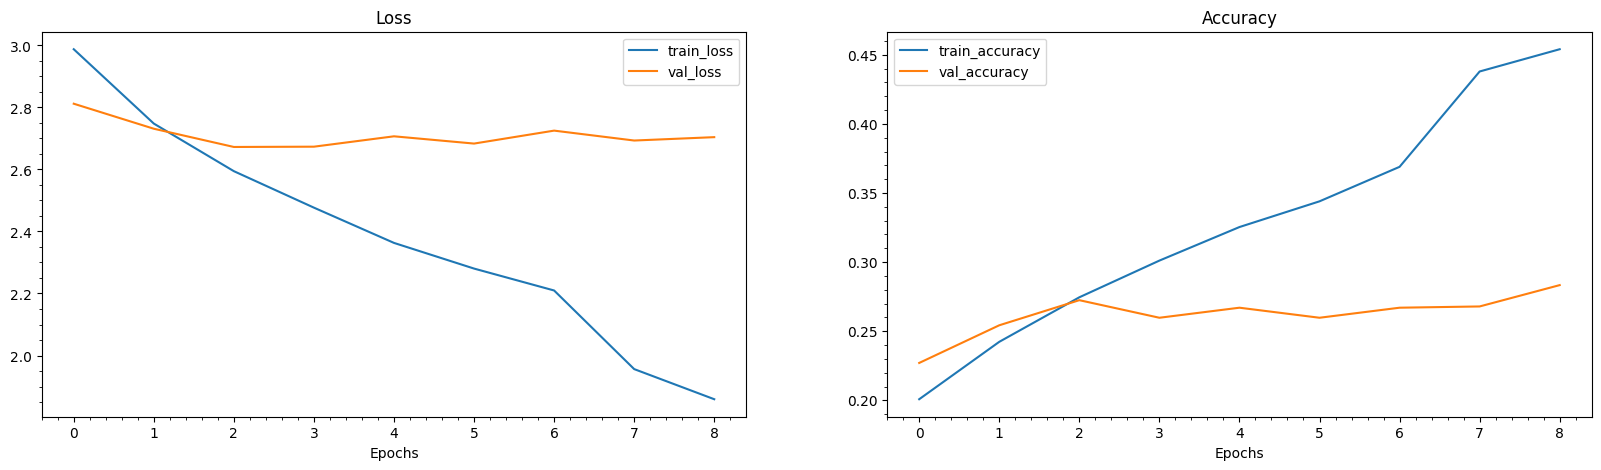

In [112]:
model_2, history_2 = fit_model(model_2, train_batches, val_batches, epochs=40)

In [113]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [114]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1,
                                min_delta = 1e-4, min_lr = 1e-4, mode = 'min', cooldown=1)
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 6,mode = 'min', restore_best_weights = True, verbose = 1)


In [115]:
base_3 = applications.VGG16(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

In [116]:
model_3 = build_model(base_3)

Epoch 1/20
138/138 [==============================] - 65s 461ms/step - loss: 3.3902 - accuracy: 0.1037 - val_loss: 3.2741 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 64s 464ms/step - loss: 3.2576 - accuracy: 0.1312 - val_loss: 3.2254 - val_accuracy: 0.1453 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 66s 476ms/step - loss: 3.2032 - accuracy: 0.1405 - val_loss: 3.1830 - val_accuracy: 0.1544 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 65s 470ms/step - loss: 3.1654 - accuracy: 0.1477 - val_loss: 3.1629 - val_accuracy: 0.1580 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 64s 461ms/step - loss: 3.1236 - accuracy: 0.1532 - val_loss: 3.1206 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 64s 465ms/step - loss: 3.0839 - accuracy: 0.1641 - val_loss: 3.0951 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 7/20
138/138 [==============================] 

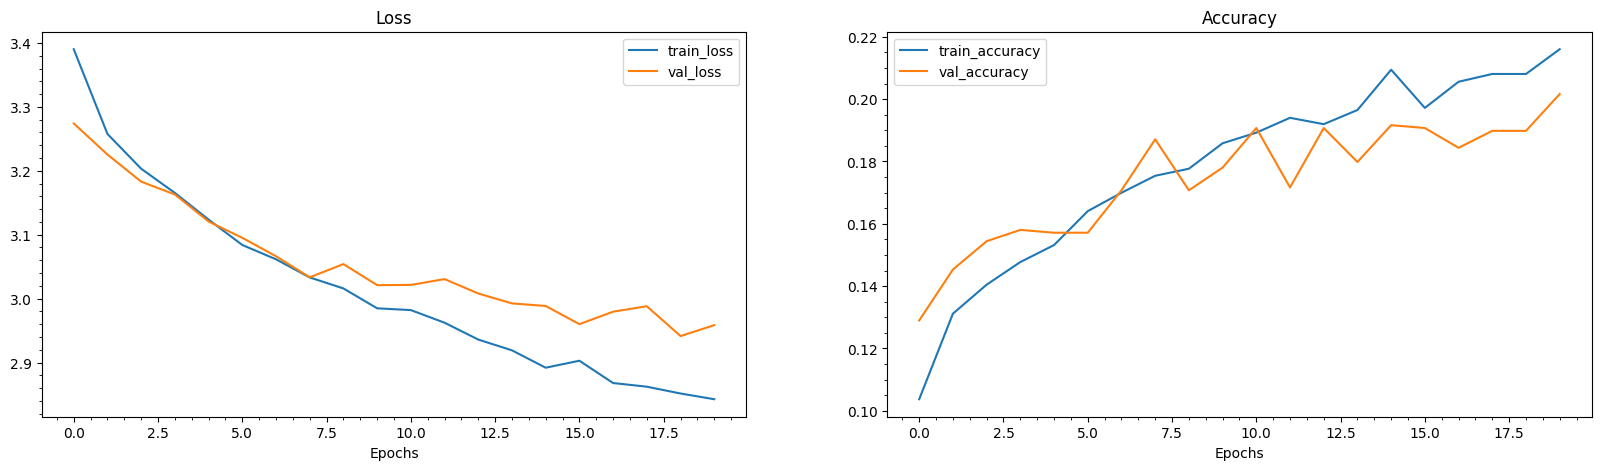

In [117]:
model_3, history_3 = fit_model(model_3, train_batches, val_batches, epochs=20)

In [118]:
base_4 = applications.DenseNet201(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

In [121]:
model_4 = build_model(base_4)

Epoch 1/20
138/138 [==============================] - 81s 506ms/step - loss: 3.2672 - accuracy: 0.1493 - val_loss: 2.9146 - val_accuracy: 0.2234 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 66s 479ms/step - loss: 2.8387 - accuracy: 0.2274 - val_loss: 2.7250 - val_accuracy: 0.2516 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 65s 468ms/step - loss: 2.6695 - accuracy: 0.2634 - val_loss: 2.7034 - val_accuracy: 0.2589 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 66s 478ms/step - loss: 2.5510 - accuracy: 0.2914 - val_loss: 2.6217 - val_accuracy: 0.2743 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 66s 478ms/step - loss: 2.4721 - accuracy: 0.3081 - val_loss: 2.5443 - val_accuracy: 0.3025 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 68s 494ms/step - loss: 2.3988 - accuracy: 0.3140 - val_loss: 2.5189 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 7/20
138/138 [==============================] 

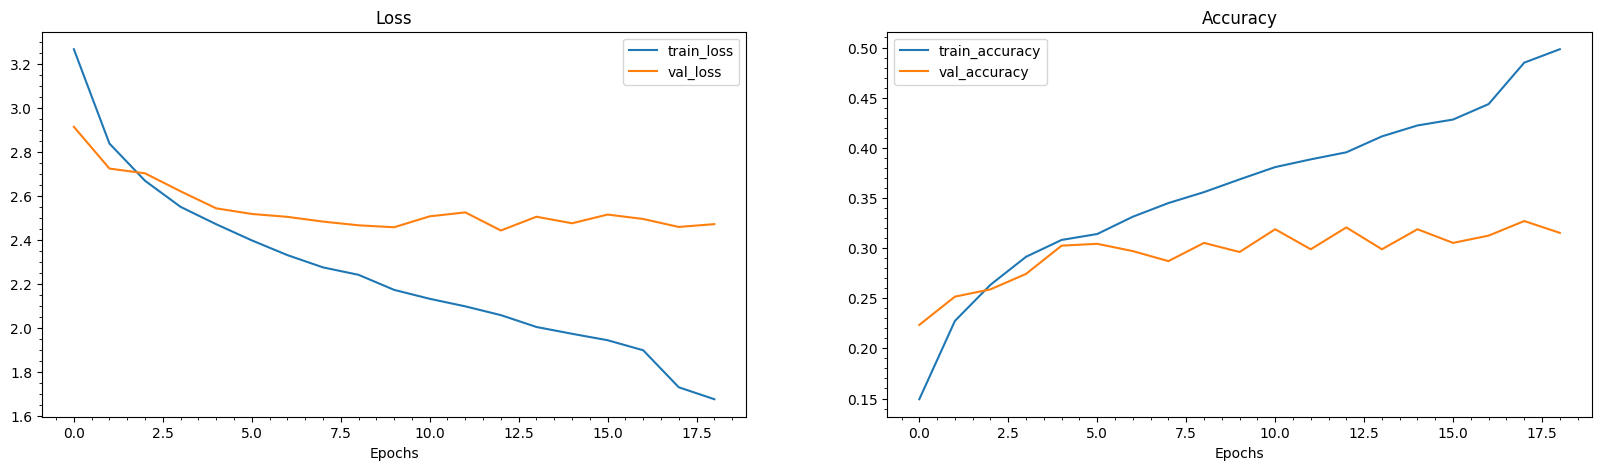

In [122]:
model_4, history_4 = fit_model(model_4, train_batches, val_batches, epochs=20)

In [61]:
from vit_keras import vit, utils

In [71]:
def create_vit_classifier():
    inputs = layers.Input(shape=(224,224))
    # Augment data.
    


    pre_trained_model = vit.vit_l32(
        image_size=(224,224),
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=True,
        classes=35
    )
    pre_trained_model.trainable = False
    features = pre_trained_model(inputs)
    features = layers.Dense(512, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(256, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(128, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)

    outputs = layers.Dense(35, activation="softmax")(features)
    model = keras.Model(inputs=inputs,outputs=outputs)
    return model

In [60]:
pip install vit_keras

  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [63]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-2,
decay_steps=10000,
decay_rate=0.9)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
       optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
history = model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights,
        validation_data=valid_generator,
        callbacks=[checkpoint_callback,early_stopping],
    )

NameError: name 'model' is not defined

In [65]:
from keras import layers

In [74]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = (224,224),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

347502902/347502902 [==============================] - 1s 0us/step


In [93]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(1, 'relu')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_5 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_9 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 128)               98432     
                                                                 
 batch_normalization_10 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_18 (Dense)            (None, 64)         

In [76]:
import tensorflow_addons as tfa

In [97]:
model.fit(x = train_data,verbose=1,
          validation_data = valid_data,
          epochs = 10)

Epoch 1/10
 56/138 [===========>..................] - ETA: 1:26 - loss: nan - accuracy: 0.0396

KeyboardInterrupt: 

In [94]:
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])